# Introduction:
Suppose you run the platelet distribution department of a blood bank. This blood bank is associated with a very critical medical center, that have a daily need for platelets. Human blood platelets are a very complicated product, because they have very short shelf life (they will be useless after 72 hours from their production) and are also very expensive to produce. The planning department of the blood bank has produced a very accurate demand estimate for the medical center, so you already know what the demand for the medical center in the next thirty days will be. Your daily production capacity is 150. The blood bank storage unit is damaged, so all produced units must head the to medical center. Producing a platelet unit costs about 50 $\$$, so all expired units represent this amount as a loss. The blood bank has estimated that every unfulfilled demand unit cost about 500 $\$$.  With all this considered, estimate an optimal (or near optimal) daily shipment schedule for the next thirty days. Suppose that at the start of the month, your hospital no platelets in stock.

Hints: 
- Think about how to represent the state of the system at any point in time.
- Think about the logic of the system, how are transitions between states perfomed?
- A production schedule is represented by a 30-number list (the shipment size for each day).
- How could you measure the performance of your shipment schedule? What is the nature of the objective function?

In [1]:
import pandas as pd
import numpy as np
demand=pd.read_csv('data/demands.csv')
demand.head(30)

,client_demand
0,96
1,110
2,141
3,87
4,108
5,113
6,88
7,109
8,120
9,118


We should define an accurate representation of the system.

In [2]:
from model.base_model import Model
class InventoryModel(Model):
    def __init__(self,initial_state,demands):
        super(InventoryModel, self).__init__(initial_state, 151, len(initial_state))
        self.demands=demands
        self.log={"expired":[],"stockouts":[],"actions":[]}
    

    def model_logic(self, state, action):
        current_day=state[0]
        platelets=state[1:]
        demand=self.demands.loc[current_day]['client_demand']
        produced_platelets=action
        platelets[-1]+=produced_platelets
        
        demand_to_fulfill=demand
        for i in range(len(platelets)):
            if demand_to_fulfill==0:
                break
            if platelets[i]>=demand_to_fulfill:
                platelets[i]-=demand_to_fulfill
                demand_to_fulfill=0
            else:
                demand_to_fulfill-=platelets[i]
                platelets[i]=0
        stockouts=demand_to_fulfill
        expired=platelets[0]
        for i in range(len(platelets)-1):
            platelets[i]=platelets[i+1]
        platelets[-1]=0
        next_state=[current_day+1]+platelets
        reward=expired*50 + stockouts*500
        self.log["expired"].append(expired)
        self.log["stockouts"].append(stockouts)
        self.log["actions"].append(action)
        return state, action, next_state, -reward, False


    def reset_model(self):
        pass

    def valid_actions(self,state):
        return {i for i in range(151)}

Now, we are going to train our agent. 

rd:     -6000.00 || Epsilon: 5.000% || Avg.Q:   3.79 || Exploitation: 93.33% || ETA:  0 hours  2 minutes
Run:       93 || Reward:    -15750.00 || Epsilon: 5.000% || Avg.Q:   2.83 || Exploitation: 96.67% || ETA:  0 hours  2 minutes
Run:       94 || Reward:     -4000.00 || Epsilon: 5.000% || Avg.Q:   2.44 || Exploitation: 96.67% || ETA:  0 hours  2 minutes
Run:       95 || Reward:   -127500.00 || Epsilon: 5.000% || Avg.Q:   2.59 || Exploitation: 93.33% || ETA:  0 hours  2 minutes
Run:       96 || Reward:    -28500.00 || Epsilon: 5.000% || Avg.Q:   2.63 || Exploitation: 93.33% || ETA:  0 hours  2 minutes
Run:       97 || Reward:    -19000.00 || Epsilon: 5.000% || Avg.Q:   2.19 || Exploitation: 96.67% || ETA:  0 hours  2 minutes
Run:       98 || Reward:    -25500.00 || Epsilon: 5.000% || Avg.Q:   1.98 || Exploitation: 93.33% || ETA:  0 hours  2 minutes
Run:       99 || Reward:         0.00 || Epsilon: 5.000% || Avg.Q:   2.30 || Exploitation: 96.67% || ETA:  0 hours  2 minutes
Run:      100

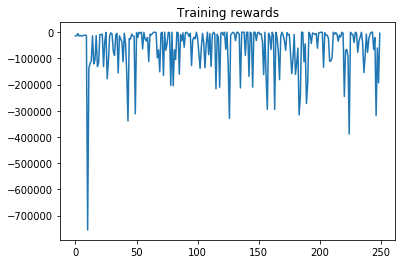

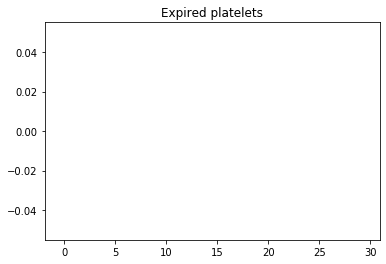

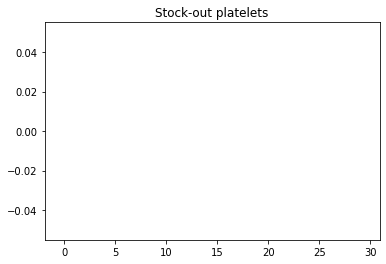

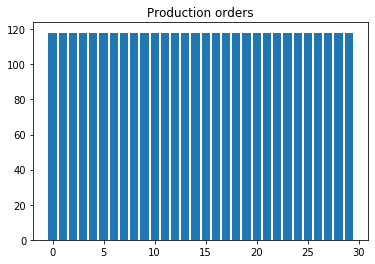

Reward of validation:0


In [5]:
from agent.rl_agent import TrainingAgent
import matplotlib.pyplot as plt
%matplotlib inline
model=InventoryModel([0,0,0,0],demand)
agent=TrainingAgent(model,runs=250,steps_per_run=30,batch_size=50,min_epsilon=0.05,use_gpu=True,epsilon_function='constant',memory=300)
train_runs=agent.run()
val_runs=agent.validate(1,30)
plt.plot(train_runs)
plt.title("Training rewards")
plt.show()
log=model.log
plt.bar(range(30),log["expired"][-30:])
plt.title("Expired platelets")
plt.show()
plt.bar(range(30),log["stockouts"][-30:])
plt.title("Stock-out platelets")
plt.show()
plt.bar(range(30),log["actions"][-30:])
plt.title("Production orders")
plt.show()
print("Reward of validation: ",val_runs[0])